In [1]:
from multi_nutrient_model import ref_parameters, perturbation_dynamics, perturbation_steady_state, I0, PARAMETER_NAMES
import numpy as np

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']



In [3]:
# Scaling 

# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


In [4]:
KI_F = 0.2
p_fited = ref_parameters( KI_F = KI_F)

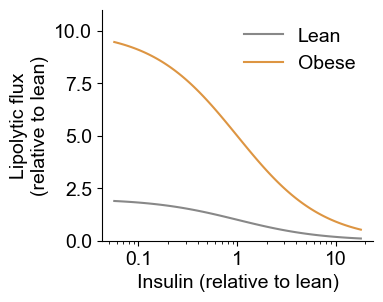

In [5]:
# Figure 6A: Illsutrate shift in liplytic propensity with insulin increase 
KI_lipo = p_fited[PARAMETER_NAMES.index('KI_lipo')]
alpha = p_fited[PARAMETER_NAMES.index('alpha')]

def lipolytic_propensity(IA,A=1.0):
    LI = 1.0 - IA / (IA + KI_lipo) 
    return alpha * A * LI 

I_range = np.logspace(-2.5,0,100)
L_range_healthy = lipolytic_propensity(I_range) / lipolytic_propensity(I0)
L_range_obese = lipolytic_propensity(I_range, A=5.0) / lipolytic_propensity(I0)

plt.figure(figsize=(3.5,3))
plt.plot(I_range/I0, L_range_healthy, label='Lean', color="#888888")
plt.plot(I_range/I0, L_range_obese, label='Obese', color="#DD9542")

plt.xlabel('Insulin (relative to lean)')
plt.ylabel('Lipolytic flux\n(relative to lean)')
plt.xscale('log')

# Make x-axis ticks
plt.xticks([ 0.1, 1, 10],
           ['0.1', '1', '10'],)
plt.legend(frameon=False)

plt.ylim(0, 11)

sns.despine()

plt.savefig('./output/lipolytic_propensity.svg', bbox_inches='tight', dpi=300)

In [6]:
# Compare the predictions to mice data of outbred mice colony
data = pd.read_table('data/BXD_metabolic_traits.tsv', index_col=0, sep='\t') 


# Normalize the data to the base line fat mass
# drop al columns that end on _SE 
data = data.drop(columns=[c for c in data.columns if c.endswith('_SE')])
# Replxa x with nan
data = data.replace('x', np.nan)

# Find data columns i.e all colums after C57BL/6J
data_columns = data.columns[data.columns.get_loc('C57BL/6J'):]

# Convert type of data columns to float
data[data_columns] = data[data_columns].astype(float)

# Average data
data_averaged = data.groupby(['Trait','Diet'])[data_columns].median().reset_index()

# Melt data 
data_averaged_melt = data_averaged.melt(id_vars=['Trait','Diet'], var_name='Strain', value_name='Value')
# Pivot to Trait as columns
data_averaged_pivot = data_averaged_melt.pivot_table(index=['Strain','Diet'], columns='Trait', values='Value').reset_index()


# Normalize to the baseline fat mass
data_averaged_pivot['Fat mass [rel]'] = data_averaged_pivot['Fat mass [g]'] / 3.5 # C57BL/6J baseline fat mass


# Compute HOMA-IR and HOMA-B
data_averaged_pivot['HOMA-IR'] = data_averaged_pivot['Insulin [ng/ml]'] * 6 * data_averaged_pivot['Glucose [mg/dl]'] / 405 
data_averaged_pivot['HOMA-B'] = data_averaged_pivot['Insulin [ng/ml]'] * 6 * 360 / (data_averaged_pivot['Glucose [mg/dl]'] - 50 ) 



In [7]:
data_averaged_pivot[ data_averaged_pivot.Strain.isin(['C57BL/6J', 'DBA/2J']) ]


Trait,Strain,Diet,Fat mass [g],Glucose [mg/dl],Insulin [ng/ml],Fat mass [rel],HOMA-IR,HOMA-B
115,C57BL/6J,CD,3.790000,109.666672,0.38700,1.082857,0.628756,14.009831
116,C57BL/6J,HFD,13.657250,163.000000,3.30000,3.902071,7.968889,63.079646
117,DBA/2J,CD,8.098125,91.893001,2.72175,2.313750,3.705330,140.333225
118,DBA/2J,HFD,16.602275,132.699997,3.78550,4.743507,7.442012,98.871588


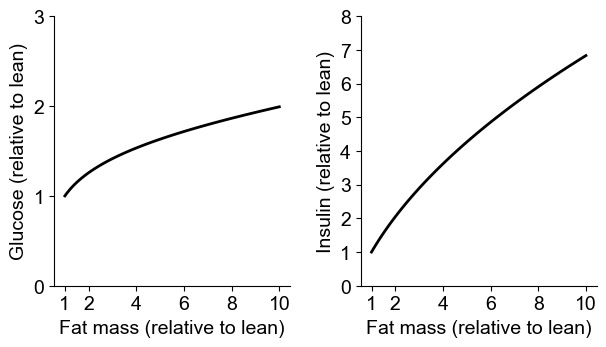

In [8]:
# Plot glucose and insulin model prediction as a function relative adiposity
# Side by side plot

# Simulate A
A = np.linspace(1, 10, 100)

results = [perturbation_steady_state(a, p=p_fited) for a in A]

# Main Figure insulin and glucose
G = np.array([r[1] for r in results])
I = np.array([r[-1] for r in results]) / I0
f, ax = plt.subplots(1, 2, figsize=(7, 3.5))

# Adjust width of the subplots
plt.subplots_adjust(wspace=0.3)

# Glucose plot
sns.lineplot(
    x=A, y=G, ax=ax[0], color="#000000", label='Model', linewidth=2,
    legend=False,
)
ax[0].set_xlabel('Fat mass (relative to lean)')
ax[0].set_ylabel('Glucose (relative to lean)')
ax[0].set_ylim(0, 3)
ax[0].set_yticks([0, 1, 2, 3])
ax[0].set_xticks([1, 2, 4, 6, 8, 10])


# Insulin plot
sns.lineplot(
    x=A, y=I, ax=ax[1], color="#000000", label='Model', linewidth=2,
    legend=False,
)
ax[1].set_xlabel('Fat mass (relative to lean)')
ax[1].set_ylabel('Insulin (relative to lean)')
ax[1].set_ylim(0, 8)
ax[1].set_yticks([0,1, 2, 3, 4, 5, 6, 7, 8])
ax[1].set_xticks([1, 2, 4, 6, 8, 10])

sns.despine()

plt.savefig('./output/obesity_hyperglycemia_hyperinsulnemia.svg', bbox_inches='tight', dpi=300)

In [9]:
A = np.linspace(1, 10, 100)

results = [perturbation_steady_state(a, p=p_fited) for a in A]

# Main Figure insulin and glucose
G = [r[1] for r in results]
I = [r[-1] for r in results]

# Compare to hyperplasicly increased adipose
p_hyper = p_fited.copy()
p_hyper[-1] = True
results_hyperplasia = [perturbation_steady_state(a, p=p_hyper) for a in A]

G_hyper = [r[1] for r in results_hyperplasia]
I_hyper = [r[-1] for r in results_hyperplasia]


# Supplementary Figure the rest 
L = [r[0] for r in results]
K = [r[2] for r in results]
F = [r[3] for r in results]

HOMA_IR = np.array(I)/I0 * 0.4 * 6 * np.array(G) * 90 / 405




In [10]:
# Make an interpolation function for the glucose and insulin data
from scipy.interpolate import interp1d
# Interpolate the glucose and insulin data
glucose_interp = interp1d(A * 3.5, np.array(G)* 90, fill_value='extrapolate')
insulin_interp = interp1d(A * 3.5, np.array(I)/I0 * 0.4, fill_value='extrapolate')

In [11]:
# Integrate equivalent simulated glucose, insulin into data_averaged_pivot
data_averaged_pivot['Glucose_sim'] = glucose_interp(data_averaged_pivot['Fat mass [g]'])
data_averaged_pivot['Insulin_sim'] = insulin_interp(data_averaged_pivot['Fat mass [g]'])

# ADD simulated HOMA-IR and HOMA-B
data_averaged_pivot['HOMA-IR_sim'] = data_averaged_pivot['Insulin_sim'] * 6 * data_averaged_pivot['Glucose_sim'] / 405
data_averaged_pivot['HOMA-B_sim'] = data_averaged_pivot['Insulin_sim'] * 6 * 360 / (data_averaged_pivot['Glucose_sim'] - 50 )

# Compute residuals between HOMA-IR and Simulation against HOMA-B
data_averaged_pivot['HOMA-IR_residual'] = data_averaged_pivot['HOMA-IR'] - data_averaged_pivot['HOMA-IR_sim']
data_averaged_pivot['HOMA-B_residual'] = data_averaged_pivot['HOMA-B'] - data_averaged_pivot['HOMA-B_sim']

# Compute R2 measure of model wit data for glucose, insulin, HOMA-IR, HOMA-B
from sklearn.metrics import r2_score
# Drop na values
data_averaged_pivot_no_na = data_averaged_pivot.dropna(subset=['Glucose [mg/dl]', 'Insulin [ng/ml]', 'HOMA-IR', 'HOMA-B',
                                                         'Glucose_sim', 'Insulin_sim', 'HOMA-IR_sim', 'HOMA-B_sim'])

r2_glucose = r2_score(data_averaged_pivot_no_na['Glucose [mg/dl]'], data_averaged_pivot_no_na['Glucose_sim'])
r2_insulin = r2_score(data_averaged_pivot_no_na['Insulin [ng/ml]'], data_averaged_pivot_no_na['Insulin_sim'])
r2_homa_ir = r2_score(data_averaged_pivot_no_na['HOMA-IR'], data_averaged_pivot_no_na['HOMA-IR_sim'])
r2_homa_b = r2_score(data_averaged_pivot_no_na['HOMA-B'], data_averaged_pivot_no_na['HOMA-B_sim'])  

# Print R2 values
print(f'R2 Glucose: {r2_glucose:.2f}')
print(f'R2 Insulin: {r2_insulin:.2f}')
print(f'R2 HOMA-IR: {r2_homa_ir:.2f}')
print(f'R2 HOMA-B: {r2_homa_b:.2f}')

R2 Glucose: 0.31
R2 Insulin: 0.27
R2 HOMA-IR: 0.31
R2 HOMA-B: 0.06


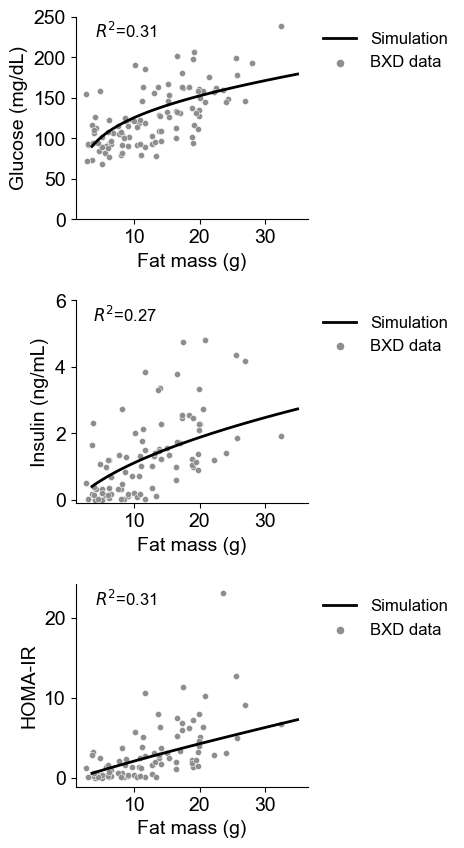

In [12]:

# Plot Glucose and Insulin
f, ax = plt.subplots(3, 1, figsize=(3, 10))
# Increase marign between subplots
plt.subplots_adjust(hspace=0.4)

# Glucose scaled to reference of 100
ax[0].plot(A * 3.5 , np.array(G)* 90, color='black', label='Simulation', linewidth=2)
sns.scatterplot(
    data=data_averaged_pivot,
    x='Fat mass [g]',
    y='Glucose [mg/dl]',
    ax=ax[0],
    color= "#8E8E8E", 
    s=20,
    legend=False
)
#sns.regplot(data = data_averaged_pivot, x='Fat mass [rel]', y='Glucose [mg/dl]', ax=ax[0], scatter=False, color='black', robust=True)


ax[0].set_ylabel('Glucose (mg/dL)')
ax[0].set_xlabel('Fat mass (g)')
ax[0].set_ylim(0, 250)

# Add legend outside of the plot
#ax[0].legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# HOMA-IR 
ax[1].plot(A * 3.5 , np.array(I)/I0 * 0.4 , color='black', label='Simulation', linewidth=2)
sns.scatterplot(data = data_averaged_pivot,
                x='Fat mass [g]', 
                y='Insulin [ng/ml]', 
                ax=ax[1], 
                color= "#8E8E8E", 
                s=20,
                legend=False
                )
ax[1].set_ylabel('Insulin (ng/mL)')
ax[1].set_xlabel('Fat mass (g)')
ax[1].set_ylim(-0.1, 6)

# HOMA-IR
ax[2].plot(A * 3.5, HOMA_IR, color='black', label='Simulation', linewidth=2)
sns.scatterplot(
    data=data_averaged_pivot,
    x='Fat mass [g]',
    y='HOMA-IR', 
    #hue='Diet',
    ax=ax[2],
    color= "#8E8E8E", 
    s=20,
)
ax[2].set_ylabel('HOMA-IR')
ax[2].set_xlabel('Fat mass (g)')
#ax[2].set_ylim(0, 40)
# Add legend outside of the plot
scatter_legend = ax[0].scatter([], [], color="#8E8E8E", s=20, label='BXD data')
ax[0].legend(frameon=False, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

scatter_legend = ax[1].scatter([], [], color="#8E8E8E", s=20, label='BXD data')
ax[1].legend(frameon=False, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

scatter_legend = ax[2].scatter([], [], color="#8E8E8E", s=20, label='BXD data')
ax[2].legend(frameon=False, fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))

# Annotate R2 values on each subplot
ax[0].text(0.35, 0.98, f'$R^2$={r2_glucose:.2f}', transform=ax[0].transAxes, ha='right', va='top', fontsize=12)
ax[1].text(0.35, 0.98, f'$R^2$={r2_insulin:.2f}', transform=ax[1].transAxes, ha='right', va='top', fontsize=12)
ax[2].text(0.35, 0.98, f'$R^2$={r2_homa_ir:.2f}', transform=ax[2].transAxes, ha='right', va='top', fontsize=12)

sns.despine()

plt.savefig('output/obesety_glucose_homa_mass_action.svg', bbox_inches='tight')


In [13]:
# Copmpute the dynamic with respect to the rest of the variables
vars = ['L','G','K','F','I','IA']
time = np.linspace(0, 10, 100)
X1,F1 = perturbation_dynamics(time, A=1, p=p_fited)
time2 = np.linspace(10+0.01, 180, 100)

X2,F2 = perturbation_dynamics(time2, A=2, p=p_fited, X0=X1.loc[10,vars].values)
# Join the results
X = pd.concat((X1, X2), axis=0)
F = pd.concat((F1, F2), axis=0) 

# Scale the results in X 
X['G'] = X['G'] * 100
X['I'] = X['I'] / I0 * 0.4
X['L'] = X['L'] * 0.75
X['K'] = X['K'] * 0.5
X['F'] = X['F'] * 0.5 

# Scale the results in F but not time
F = F * vATP
F['time'] = F['time']/vATP

# Compute net FA release 
F['vFA'] = F['vA'] - F['vR']

# Compute net gluocse disposal 
F['vGD'] = F['vG'] + F['vGL']

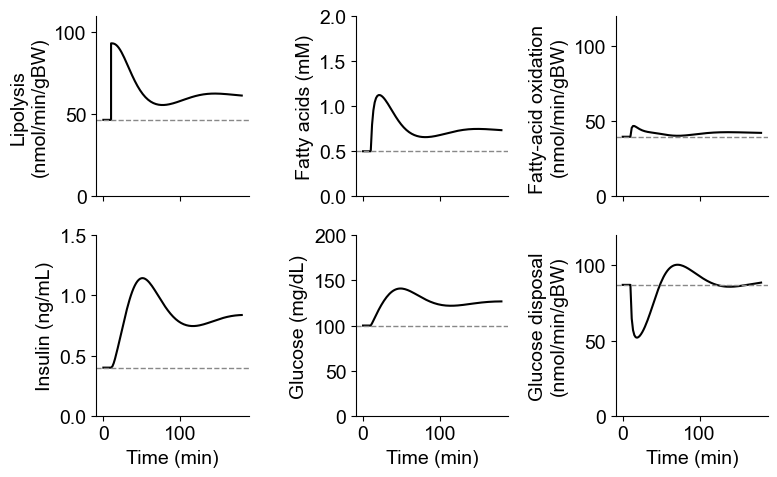

In [14]:
# Make 2 rows 3 columns plot
f, ax = plt.subplots(2, 3, figsize=(8, 5), sharex=True)
# Increease the margin between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Lipolysis
sns.lineplot(data=F, x='time', y='vA', ax=ax[0, 0], color='black')

ax[0, 0].set_ylabel('Lipolysis\n(nmol/min/gBW)')
# ylimt
ax[0, 0].set_ylim(0, 110)

# Fatty acid
sns.lineplot(data=X, x='time', y='F', ax=ax[0, 1], color='black')
ax[0, 1].set_ylabel('Fatty acids (mM)')
ax[0, 1].set_xlabel('Time (min)')
# ylimt
ax[0, 1].set_ylim(0, 2.0)

# vF 
sns.lineplot(data=F, x='time', y='vF', ax=ax[0, 2], color='black')
ax[0, 2].set_ylabel('Fatty-acid oxidation \n(nmol/min/gBW)')
# ylimt
ax[0, 2].set_ylim(0, 120)

# vG and vGL
sns.lineplot(data=F, x='time', y='vGD', ax=ax[1, 2], color='black', )
ax[1, 2].set_ylabel('Glucose disposal\n(nmol/min/gBW)')
# Move the legent a bit outside
# ax[1, 2].legend(frameon=False, loc='upper right', bbox_to_anchor=(1.5, 1.1))
ax[1, 2].set_xlabel('Time (min)')
# ylimt
ax[1, 2].set_ylim(0, 120)


# Glucose 
sns.lineplot(data=X, x='time', y='G', ax=ax[1, 1], color='black')
ax[1, 1].set_ylabel('Glucose (mg/dL)')
ax[1, 1].set_xlabel('Time (min)')
ax[1, 1].set_ylim(0, 200)


# Insulin
sns.lineplot(data=X, x='time', y='I', ax=ax[1, 0], color='black')
ax[1, 0].set_ylabel('Insulin (ng/mL)')
ax[1, 0].set_xlabel('Time (min)')
ax[1, 0].set_ylim(0, 1.5)


plt.tight_layout()
sns.despine()
# Add dashed horizontal lines at the starting level in each plot (grey color)
ax[0, 0].axhline(F['vA'].iloc[0], color='#888888', linestyle='--', linewidth=1)
ax[0, 1].axhline(X['F'].iloc[0], color='#888888', linestyle='--', linewidth=1)
ax[0, 2].axhline(F['vF'].iloc[0], color='#888888', linestyle='--', linewidth=1)
ax[1, 0].axhline(X['I'].iloc[0], color='#888888', linestyle='--', linewidth=1)
ax[1, 1].axhline(X['G'].iloc[0], color='#888888', linestyle='--', linewidth=1)
ax[1, 2].axhline(F['vGD'].iloc[0], color='#888888', linestyle='--', linewidth=1)

plt.savefig('output/sponteanous_obesity_dynamics.svg', bbox_inches='tight')
